In [1]:
import math

import cv2
import matplotlib.pyplot as plt
import numpy as np

from mmdet.apis import init_detector, inference_detector

/home/cry/anaconda3/envs/detX/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/cry/anaconda3/envs/detX/lib/python3.9/site-packages/mmcv/__init__.py:20: UserWarning: On January 1, 2023, MMCV will release v2.0.0, in which it will remove components related to the training process and add a data transformation module. In addition, it will rename the package names mmcv to mmcv-lite and mmcv-full to mmcv. See https://github.com/open-mmlab/mmcv/blob/master/docs/en/compatibility.md for more details.
  warnings.warn(


In [3]:
# you can download the config and model checkpoint from: https://huggingface.co/RuoyuChen/objectdetection-saliency-maps/
config = 'work_dirs/yolo_v3/yolo_v3.py'
checkpoint = 'work_dirs/yolo_v3/latest.pth'
device = 'cuda:0'
model = init_detector(config, checkpoint, device)

load checkpoint from local path: work_dirs/yolo_v3/latest.pth


In [4]:
label_names = [
    'person bev', 'car bev', 'van bev', 'truck bev', 'bus bev',
    'person', 'car', 'aeroplane', 'bus', 'train', 'truck', 'boat',
    'bird', 'camouflage man'
]

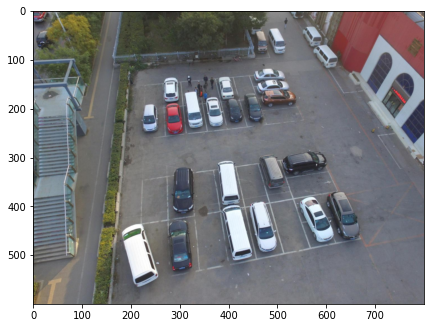

In [5]:
image_path = "../image/9999962_00000_d_0000088.jpg"
image = cv2.imread(image_path)
scale = 600 / min(image.shape[:2])
image = cv2.resize(image,
                   None,
                   fx=scale,
                   fy=scale,
                   interpolation=cv2.INTER_AREA)
plt.figure(figsize=(7, 7))
plt.imshow(image[:, :, ::-1])
plt.show()

In [34]:
scale

0.5714285714285714

/home/cry/data4/Demo/mmdetection/mmdet/datasets/utils.py:65: UserWarning: "ImageToTensor" pipeline is replaced by "DefaultFormatBundle" for batch inference. It is recommended to manually replace it in the test data pipeline in your config file.
  warnings.warn(


0 person bev (514, 14, 522, 31) 0.77577394
0 person bev (319, 137, 329, 155) 0.7288462
0 person bev (343, 139, 353, 158) 0.5725673
0 person bev (361, 136, 369, 154) 0.5605547
0 person bev (312, 136, 321, 152) 0.501928
1 car bev (354, 177, 390, 235) 0.9703805
1 car bev (509, 289, 601, 335) 0.9184666
1 car bev (464, 157, 539, 194) 0.9031688
1 car bev (433, 172, 470, 226) 0.8871673
1 car bev (395, 178, 430, 231) 0.8554236
1 car bev (454, 115, 519, 149) 0.8236232
1 car bev (549, 380, 616, 468) 0.7981711
1 car bev (381, 135, 408, 181) 0.71209407
1 car bev (459, 134, 525, 168) 0.7104878
1 car bev (273, 185, 306, 250) 0.7013289
1 car bev (280, 435, 326, 535) 0.5923188
2 van bev (465, 294, 518, 366) 0.80898744
2 van bev (311, 170, 350, 238) 0.58792126
2 van bev (557, 34, 588, 70) 0.56304455


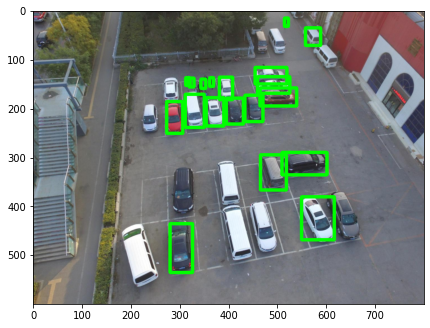

In [6]:
out = inference_detector(model, image)
res = image.copy()
for i, pred in enumerate(out):
    for *box, score in pred:
        if score < 0.5:
            break
        box = tuple(np.round(box).astype(int).tolist())
        print(i, label_names[i], box, score)
        cv2.rectangle(res, box[:2], box[2:], (0, 255, 0), 5)

plt.figure(figsize=(7, 7))
plt.imshow(res[:, :, ::-1])
plt.show()

In [7]:
def generate_mask(image_size, grid_size, prob_thresh):
    image_w, image_h = image_size
    grid_w, grid_h = grid_size
    cell_w, cell_h = math.ceil(image_w / grid_w), math.ceil(image_h / grid_h)
    up_w, up_h = (grid_w + 1) * cell_w, (grid_h + 1) * cell_h

    mask = (np.random.uniform(0, 1, size=(grid_h, grid_w)) <
            prob_thresh).astype(np.float32)
    mask = cv2.resize(mask, (up_w, up_h), interpolation=cv2.INTER_LINEAR)
    offset_w = np.random.randint(0, cell_w)
    offset_h = np.random.randint(0, cell_h)
    mask = mask[offset_h:offset_h + image_h, offset_w:offset_w + image_w]
    return mask

In [8]:
def mask_image(image, mask):
    masked = ((image.astype(np.float32) / 255 * np.dstack([mask] * 3)) *
              255).astype(np.uint8)
    return masked

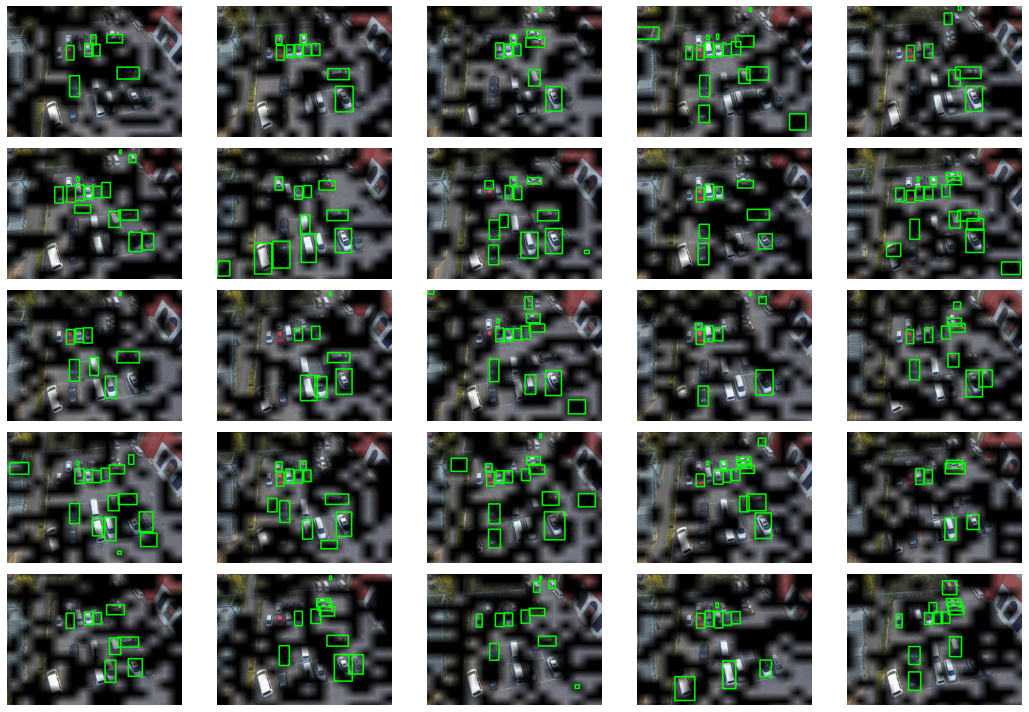

In [11]:
np.random.seed(0)

image_h, image_w = image.shape[:2]

images = []
for _ in range(25):
    mask = generate_mask(image_size=(image_w, image_h),
                         grid_size=(16, 16),
                         prob_thresh=0.5)
    masked = mask_image(image, mask)
    out = inference_detector(model, masked)
    res = masked.copy()
    for pred in out:
        for *box, score in pred:
            if score < 0.5:
                break
            box = tuple(np.round(box).astype(int).tolist())
            cv2.rectangle(res, box[:2], box[2:], (0, 255, 0), 5)
    images.append(res)

fig = plt.figure(figsize=(15, 10))
axes = fig.subplots(5, 5)
for i in range(5):
    for j in range(5):
        axes[i][j].imshow(images[i * 5 + j][:, :, ::-1])
        axes[i][j].axis('off')
plt.tight_layout()
plt.show()

In [12]:
def iou(box1, box2):
    box1 = np.asarray(box1)
    box2 = np.asarray(box2)
    tl = np.vstack([box1[:2], box2[:2]]).max(axis=0)
    br = np.vstack([box1[2:], box2[2:]]).min(axis=0)
    intersection = np.prod(br - tl) * np.all(tl < br).astype(float)
    area1 = np.prod(box1[2:] - box1[:2])
    area2 = np.prod(box2[2:] - box2[:2])
    return intersection / (area1 + area2 - intersection)

In [13]:
def generate_saliency_map(image,
                          target_class_index,
                          target_box,
                          prob_thresh=0.5,
                          grid_size=(16, 16),
                          n_masks=5000,
                          seed=0):
    np.random.seed(seed)
    image_h, image_w = image.shape[:2]
    res = np.zeros((image_h, image_w), dtype=np.float32)
    for _ in range(n_masks):
        mask = generate_mask(image_size=(image_w, image_h),
                             grid_size=grid_size,
                             prob_thresh=prob_thresh)
        masked = mask_image(image, mask)
        out = inference_detector(model, masked)
        pred = out[target_class_index]
        score = max([iou(target_box, box) * score for *box, score in pred],
                    default=0)
        res += mask * score
    return res

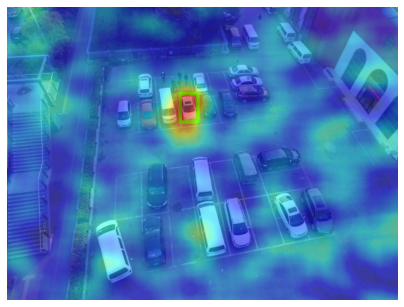

In [16]:
target_box = np.array([354, 177, 390, 235])
target_box = target_box.astype(int)
saliency_map = generate_saliency_map(image,
                                     target_class_index=1,
                                     target_box=target_box,
                                     prob_thresh=0.5,
                                     grid_size=(16, 16),
                                     n_masks=1000)

image_with_bbox = image.copy()
cv2.rectangle(image_with_bbox, tuple(target_box[:2]), tuple(target_box[2:]),
              (0, 255, 0), 5)
plt.figure(figsize=(7, 7))
plt.imshow(image_with_bbox[:, :, ::-1])
plt.imshow(saliency_map, cmap='jet', alpha=0.5)
plt.axis('off')
plt.show()

In [35]:
target_box = np.array([678, 696, 106, 196])*scale

In [37]:
target_box.astype(int)

array([387, 397,  60, 112])